In [33]:
import sys
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs
import nltk
from nltk.corpus import stopwords


from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from process_websites import get_corpus
from my_models import categoryDetection, unify_yelp_data_classes, plot_classes_distribution, testing, find_wrongs, get_classes_distribution


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    if sys.version_info > (3.0):
        os.system('python3 -m nltk.downloader stopwords')
    else:
        os.system('pyhton -m nltk.downloader.stopwords')
        
FOLDER_PATH = '/home/vahidsanei_google_com/'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [3]:
!python -m nltk.downloader stopwords

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vahidsanei_google_com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus.csv')
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [5]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       'is_eng', 'webpage_corpus'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78568 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      78568 non-null  int64  
 1   business_id     78568 non-null  object 
 2   name            78568 non-null  object 
 3   address         75147 non-null  object 
 4   city            78568 non-null  object 
 5   state           78568 non-null  object 
 6   postal_code     78410 non-null  object 
 7   latitude        78568 non-null  float64
 8   longitude       78568 non-null  float64
 9   stars           78568 non-null  float64
 10  review_count    78568 non-null  int64  
 11  is_open         78568 non-null  int64  
 12  attributes      67645 non-null  object 
 13  categories      78514 non-null  object 
 14  hours           67573 non-null  object 
 15  url             78568 non-null  object 
 16  webpage_text    78568 non-null  object 
 17  is_eng          78568 non-null 

In [7]:
for url, corpus in zip(df['url'][-10:], df['webpage_corpus'][-10:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.thedakotaatcamelback.com
##################################################
Sorry An error has occured No domain data found for domain wwwthedakotaatcamelbackcom 2020 RentPath LLC All rights reserved All photos videos and floor plans are the property of RentPath LLC All text is the property of this property RentPath is in no way affiliated with the management or ownership of this property
**************************************************
http://www.alyshaan.com
##################################################
https://www.kfc.ca//store/415-mount-pleasant-rd-toronto
##################################################
Be A Franais Sign in FOR SHARING FOR ONE DEALS 0 000 START MY ORDER 415 Mount Pleasant Rd Hours Sunday 1100 AM1000 PM Monday 1100 AM1000 PM Tuesday 1100 AM1000 PM Wednesday 1100 AM1000 PM Thursday 1100 AM1000 PM Friday 1100 AM1000 PM Saturday 1100 AM1000 PM 415 Mount Pleasant Rd 4164810900 Choose Another Location Store Details 415 Mount Pleasant Rd Toronto ON M4

In [8]:
df_sentsplit = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus_sent_split.csv')
df_sentsplit.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [9]:
for url, corpus in zip(df['url'][-5:], df['webpage_corpus'][-5:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.salonfortytwo.com
##################################################
Salon 42 Home Story Services Salons Tribe 42 Weddings Our Press Contact Us Home Story Services Salons Tribe 42 Weddings Our Press Contact Us 42 The answer to life the universe and everything Especially for Hair Salon 42 New Salon Coming Soon To beautiful sunny Charleston SC But for now continue to visit us atxe2x80xa6 Southparkxe2x80xa6 Charlotte NC Indian Landxe2x80xa6Indian Land SC Dilworth xe2x80xa6 Charlotte NC Lake Norman xe2x80xa6 Corneliua NC Did you know 42 people move into Charlotte everydayxe2x80xa6 yepxe2x80xa6itxe2x80x99s our magic number again and we hope to see them all here at Salon 42 What Else is New Learn About the Life of 42xe2x80xa6 42 is the answer to Life the Universe and Everything according to Douglas Adams and the book xe2x80x9cHitchhikers Guide to the Galaxy 42 degrees is the angle at which light must reflect off water in order to create a rainbow The Titanic was traveling at a spe

In [10]:
for url, corpus in zip(df_sentsplit['url'][-5:], df_sentsplit['webpage_corpus'][-5:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.salonfortytwo.com
##################################################
Salon 42 Home Story Services Salons Tribe 42 Weddings Our Press Contact Us Home Story Services Salons Tribe 42 Weddings Our Press Contact Us 42 The answer to life the universe and everything#Especially for Hair Salon 42 New Salon Coming Soon To beautiful sunny Charleston SC But for now continue to visit us atxe2x80xa6 Southparkxe2x80xa6 Charlotte NC Indian Landxe2x80xa6Indian Land SC Dilworth xe2x80xa6 Charlotte NC Lake Norman xe2x80xa6 Corneliua NC Did you know#42 people move into Charlotte everydayxe2x80xa6 yepxe2x80xa6itxe2x80x99s our magic number again and we hope to see them all here at Salon 42#What Else is New#Learn About the Life of 42xe2x80xa6 42 is the answer to Life the Universe and Everything according to Douglas Adams and the book xe2x80x9cHitchhikers Guide to the Galaxy#42 degrees is the angle at which light must reflect off water in order to create a rainbow#The Titanic was traveling at a spe

In [11]:
saved_df = df.copy()
saved_df_sentsplit = df_sentsplit.copy()

In [12]:
df = saved_df.copy()
df_sentsplit = saved_df_sentsplit.copy()

In [13]:
df = unify_yelp_data_classes(df, show_skipped=False);

/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))
/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = cat


In [14]:
df_sentsplit = unify_yelp_data_classes(df_sentsplit, show_skipped=False);

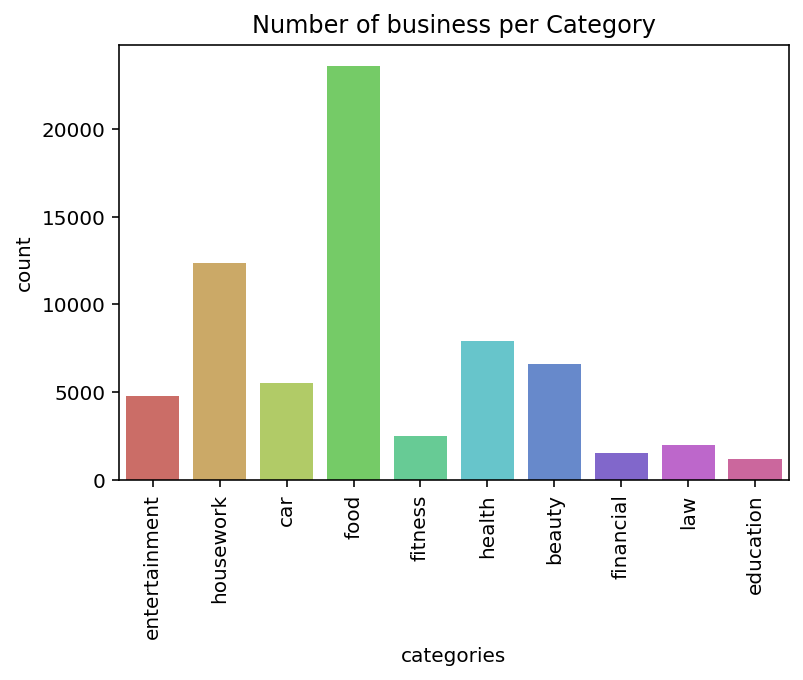

In [15]:
plot_classes_distribution(df)

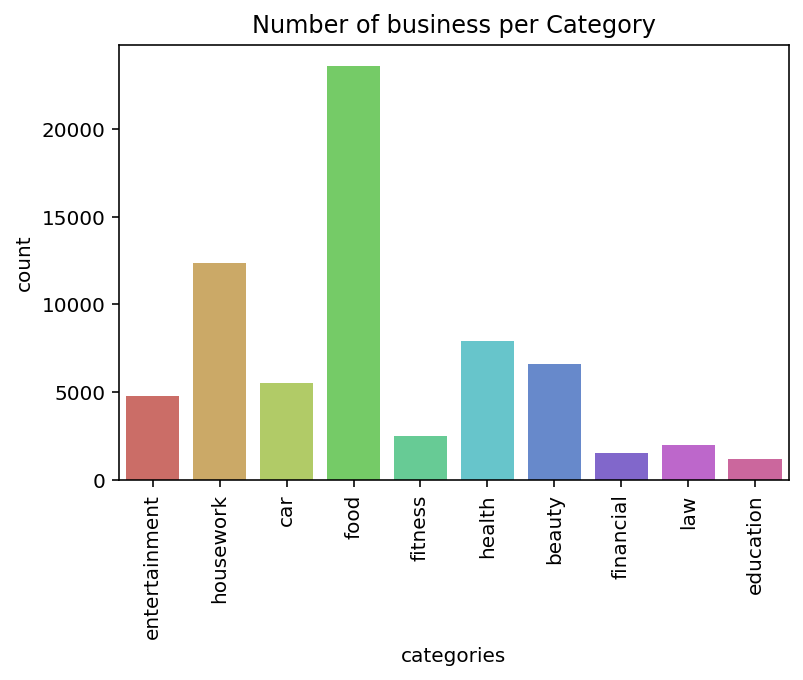

In [16]:
plot_classes_distribution(df_sentsplit)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67945 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      67945 non-null  int64  
 1   business_id     67945 non-null  object 
 2   name            67945 non-null  object 
 3   address         65177 non-null  object 
 4   city            67945 non-null  object 
 5   state           67945 non-null  object 
 6   postal_code     67813 non-null  object 
 7   latitude        67945 non-null  float64
 8   longitude       67945 non-null  float64
 9   stars           67945 non-null  float64
 10  review_count    67945 non-null  int64  
 11  is_open         67945 non-null  int64  
 12  attributes      59391 non-null  object 
 13  categories      67945 non-null  object 
 14  hours           59100 non-null  object 
 15  url             67945 non-null  object 
 16  webpage_text    67945 non-null  object 
 17  is_eng          67945 non-null 

In [18]:
folder_path = os.path.join(FOLDER_PATH, 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [19]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [20]:
cat1 = categoryDetection(train, test, tokenizer, max_seq_len=128)

34858it [07:20, 79.16it/s] 
12it [00:00, 108.66it/s]

Removed 17.875380113603768% of entries, due to being short corpus length.


8677it [01:50, 78.78it/s] 


Removed 18.047712342975686% of entries, due to being short corpus length.
size of each balanced class =  601


# Baseline with Unbalanced Training Set

In [ ]:
get_classes_distribution(cat1.train_y, cat1.classes)

In [26]:
model1 = cat1.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128);
cat1.compile_model(model1, cat1.train_x, cat1.train_y, n_epochs=20);
print('Accuracy on test set:')
model1.evaluate(cat1.test_x, cat1.test_y);

loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/output/

loader: No value for:[bert/encoder/layer_5/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_5/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_5/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_5/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_5/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_5/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_6/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/un

loader: No value for:[bert/encoder/layer_10/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_10/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_10/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_10/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_10/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_10/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_10/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_10/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_11/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_11/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

# Baseline with Balanced Training Set

In [34]:
get_classes_distribution(cat1.balanced_train_y, cat1.classes)

class beauty = 10.0%
class car = 10.0%
class education = 10.0%
class entertainment = 10.0%
class financial = 10.0%
class fitness = 10.0%
class food = 10.0%
class health = 10.0%
class housework = 10.0%
class law = 10.0%


In [35]:
model1_bal = cat1.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128)
cat1.compile_model(model1_bal, cat1.balanced_train_x, cat1.balanced_train_y, n_epochs=20)
print('Accuracy on test set:')
model1_bal.evaluate(cat1.test_x, cat1.test_y);

loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_1/encoder/layer_7/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_7/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_7/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_7/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

357/357 [==============================] - 62s 173ms/step - loss: 2.3003 - acc: 0.1132 - val_loss: 2.3383 - val_acc: 0.0831
Epoch 2/20
357/357 [==============================] - 55s 155ms/step - loss: 2.2870 - acc: 0.1457 - val_loss: 2.3078 - val_acc: 0.2292
Epoch 3/20
357/357 [==============================] - 56s 158ms/step - loss: 2.1338 - acc: 0.3852 - val_loss: 2.1678 - val_acc: 0.2791
Epoch 4/20
357/357 [==============================] - 55s 155ms/step - loss: 1.9032 - acc: 0.6043 - val_loss: 2.1405 - val_acc: 0.3090
Epoch 5/20
357/357 [==============================] - 54s 153ms/step - loss: 1.8156 - acc: 0.6786 - val_loss: 2.1292 - val_acc: 0.3123
Epoch 6/20
357/357 [==============================] - 54s 150ms/step - loss: 1.7743 - acc: 0.7098 - val_loss: 2.1291 - val_acc: 0.3123
Epoch 7/20
357/357 [==============================] - 54s 150ms/step - loss: 1.7521 - acc: 0.7248 - val_loss: 2.1299 - val_acc: 0.3123
Epoch 8/20
357/357 [==============================] - 54s 150ms/st

In [58]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model1, cat1, LEN=128)
testing(text, model1_bal, cat1, LEN=128)

food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.01%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('99.98%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]


In [59]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model1, cat1, LEN=128)
testing(text, model1_bal, cat1, LEN=128)

car
[('0.01%', 'beauty'), ('63.24%', 'car'), ('3.83%', 'education'), ('26.0%', 'entertainment'), ('2.48%', 'financial'), ('0.15%', 'fitness'), ('0.1%', 'food'), ('0.07%', 'health'), ('0.03%', 'housework'), ('4.09%', 'law')]
car
[('0.01%', 'beauty'), ('94.62%', 'car'), ('1.68%', 'education'), ('0.58%', 'entertainment'), ('0.7%', 'financial'), ('0.47%', 'fitness'), ('0.06%', 'food'), ('0.05%', 'health'), ('1.75%', 'housework'), ('0.09%', 'law')]


In [38]:
split_sz = int(len(df_sentsplit) * 0.8)
train = df_sentsplit[:split_sz]
test = df_sentsplit[split_sz:]

# Reformating the corpus using Glove embeddings

In [39]:
glove_address = os.path.join(FOLDER_PATH, 'data', 'glove_data', 'glove.6B.300d.txt')

In [40]:
cat2 = categoryDetection(train, test, tokenizer, max_seq_len=128, glove_embeddings_address=glove_address, glove_sentence_similarity=True)

34865it [15:42, 37.01it/s]
7it [00:00, 69.88it/s]

Removed 17.85458195898465% of entries, due to being short corpus length.


8662it [03:45, 38.40it/s]


Removed 18.29831447702609% of entries, due to being short corpus length.
size of each balanced class =  598


# Glove similarity with Unbal. Training Data

In [41]:
get_classes_distribution(cat2.train_y, cat2.classes)

class beauty = 10.59%
class car = 9.12%
class education = 2.09%
class entertainment = 7.6%
class financial = 2.69%
class fitness = 4.18%
class food = 29.33%
class health = 12.07%
class housework = 19.25%
class law = 3.08%


In [42]:
model2 = cat2.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128)
cat2.compile_model(model2, cat2.train_x, cat2.train_y, n_epochs=20)
print('Accuracy on test set:')
model2.evaluate(cat2.test_x, cat2.test_y);

loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_2/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

1701/1701 [==============================] - 265s 156ms/step - loss: 2.0199 - acc: 0.4445 - val_loss: 1.8897 - val_acc: 0.5656
Epoch 2/20
1701/1701 [==============================] - 257s 151ms/step - loss: 1.7821 - acc: 0.6843 - val_loss: 1.7116 - val_acc: 0.7577
Epoch 3/20
1701/1701 [==============================] - 259s 152ms/step - loss: 1.7045 - acc: 0.7625 - val_loss: 1.6806 - val_acc: 0.7842
Epoch 4/20
1701/1701 [==============================] - 260s 153ms/step - loss: 1.6847 - acc: 0.7786 - val_loss: 1.6700 - val_acc: 0.7919
Epoch 5/20
1701/1701 [==============================] - 261s 154ms/step - loss: 1.6773 - acc: 0.7854 - val_loss: 1.6654 - val_acc: 0.7968
Epoch 6/20
1701/1701 [==============================] - 257s 151ms/step - loss: 1.6717 - acc: 0.7893 - val_loss: 1.6685 - val_acc: 0.7884
Epoch 7/20
1701/1701 [==============================] - 260s 153ms/step - loss: 1.6559 - acc: 0.8079 - val_loss: 1.6430 - val_acc: 0.8198
Epoch 8/20
1701/1701 [=======================

# Glove similarity with Bal. Training Data

In [43]:
model2_bal = cat2.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128);
cat2.compile_model(model2_bal, cat2.balanced_train_x, cat2.balanced_train_y, n_epochs=20);
print('Accuracy on test set:')
model2_bal.evaluate(cat2.test_x, cat2.test_y);

loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_3/encoder/layer_6/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_6/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_6/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_6/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_6/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_6/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6f2b9a5d0> (prefix:bert_3). Count of weights not found in the checkpoint was: [96]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)     

In [47]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model2, cat2, LEN=128)
testing(text, model2_bal, cat2, LEN=128)

food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.07%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('99.88%', 'food'), ('0.0%', 'health'), ('0.03%', 'housework'), ('0.01%', 'law')]


In [48]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model2, cat2, LEN=128)
testing(text, model2_bal, cat2, LEN=128)

entertainment
[('0.04%', 'beauty'), ('10.03%', 'car'), ('0.33%', 'education'), ('68.14%', 'entertainment'), ('3.33%', 'financial'), ('6.09%', 'fitness'), ('0.07%', 'food'), ('0.58%', 'health'), ('3.1%', 'housework'), ('8.28%', 'law')]
car
[('0.0%', 'beauty'), ('82.89%', 'car'), ('3.3%', 'education'), ('0.82%', 'entertainment'), ('0.76%', 'financial'), ('0.06%', 'fitness'), ('0.01%', 'food'), ('0.01%', 'health'), ('12.15%', 'housework'), ('0.01%', 'law')]


# Reformating the corpus using Bert

In [51]:
cat3 = categoryDetection(train, test, tokenizer, max_seq_len=128, bert_sentence_similarity=True, bert_ckpt_file=bert_ckpt_file, bert_config_file=bert_config_file, bert_pretrained_max_sent_len=20)

Preparing data for the pretraining step ...


34865it [07:15, 80.01it/s] 


Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6cf3bc6d0> (prefix:bert_5). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Pretraining model ...
size of each balanced class =  22232
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 20)]              0         
__________________________________________________________

20it [00:32,  1.23it/s]

TCC at 2162 E Williams Field Rd in Gilbert AZ Verizon Wireless Retailer Smartphones Tablets Skip to content Return to Nav Home Offers The TCC Difference Careers Locations Home Offers The TCC Difference Careers Locations All TCC Locations AZ Gilbert 2162 E Williams Field Rd Introducing Curbside Service Get full wireless service without leaving your car#Just pull up and give us a call to let us know youxe2x80x99re here#Available at select locations#Call us to see if we offer it Learn more about TCCxe2x80x99s response to COVID19 here#TCC Gilbert AZ San Tan Village Mall 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1200 PM 600 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1200 PM 600 PM Store Hours Day of the Week Hours Monday 1100 AM 700 PM Tuesday 1100 AM 700 PM Wednesday 1100 AM 700 PM Thursday 1100 AM 700 PM Friday 1100 AM 700 PM Saturday 1100 AM 700 PM Sunday 1200 PM 600 PM Address 2162 E Willia

21it [00:33,  1.01it/s]

Available at select locations We offer a wide selection of devices along with Verizon 4G LTE network coverage TCC Gilbert AZ San Tan Village Mall 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1200 PM 600 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1100 AM 700 PM 1200 PM 600 PM Store Hours Day of the Week Hours Monday 1100 AM 700 PM Tuesday 1100 AM 700 PM Wednesday 1100 AM 700 PM Thursday 1100 AM 700 PM Friday 1100 AM 700 PM Saturday 1100 AM 700 PM Sunday 1200 PM 600 PM Address 2162 E Williams Field Rd 324 Gilbert AZ 85295 US Main Number 480 8993238 480 8993238 Get Directions Get Deals Store Hours Day of the Week Hours Monday 1100 AM 700 PM Tuesday 1100 AM 700 PM Wednesday 1100 AM 700 PM Thursday 1100 AM 700 PM Friday 1100 AM 700 PM Saturday 1100 AM 700 PM Sunday 1200 PM 600 PM TCC is a Top Workplace We are so excited to announce that TCC has been named a Top Workplace in Indiana by IndyStar Just pull up and g

115it [02:32,  1.49s/it]

Not Acceptable#Not Acceptable#An appropriate representation of the requested resource could not be found on this server#This error was generated by ModSecurity
****************************************************************************************************


116it [02:32,  1.13s/it]

This error was generated by ModSecurity An appropriate representation of the requested resource could not be found on this server Not Acceptable Not Acceptable
####################################################################################################
####################################################################################################


123it [02:38,  1.18s/it]

South Scottsdale AZ Senior Living near Tempe McDowell Village Menu Our Community Our Community Wellness Resident Enrichment Dining Experience Care Philosophy Making a Difference Reviews Testimonials Fitness Care Services Care Services Assisted Living Independent Living Short Term Stays Floor Plans Gallery Contact Us Contact Us Directions 6232271692 Email UP DOWN 6232271692 You are using an older unsupported browser#Please visit this link to contact us COVID19 novel coronavirus Prevention Efforts Click here to read MBKs Response Dismiss Start Your Journey with Us Schedule A Virtual Tour Welcome to McDowell Village Begin the next chapter at our stunning senior living community in scenic Scottsdale AZ#Located minutes from the Phoenix Zoo and Papago Park in view of the surrounding majestic mountains McDowell Village offers modern Independent Living and Assisted Living for active people as well as ShortTerm stays#Sayxc2xa0goodbyexc2xa0to the obligations of household maintenance and come hom

124it [02:40,  1.32s/it]

A personal trainer can even create an individualized workout Our monthly calendar is bursting with opportunity for cultural enrichment wellbeing and engagement Life is delicious here thanks to three fresh locally sourced meals prepared by the talented culinary professionals in our gourmetxc2xa0 MBK Cuisinexc2xa0dining program Our fitness center offers an invigorating selection of activities from yoga and Tai Chi to Zumba and kickboxing Community members can lounge on the sundeck by our refreshing pool or enjoy the view from under a sunshade Located minutes from the Phoenix Zoo and Papago Park in view of the surrounding majestic mountains McDowell Village offers modern Independent Living and Assisted Living for active people as well as ShortTerm stays This is more than a place to live itxe2x80x99s a place to thrive Residents here enjoy exclusive access toxc2xa0community amenities starting with our gorgeous landscape of blooming desert plants towering palms and meandering walking paths W

125it [02:43,  1.88s/it]

Calgary Curling Club Login Username Password Remember Me Forget#Forget your password#Username or Email Remember Password#Home About Contact Hours Advertising with CCC League Information Associate Leagues Events at CCC Employment Opportunities Calgary Curling Club Rules Picture Gallery New to Curling Practice Ice Calendar Plan an Event Links Forms Member Log In Directors Scholarship Home About Contact Hours Advertising with CCC League Information Associate Leagues Events at CCC Employment Opportunities Calgary Curling Club Rules Picture Gallery New to Curling Practice Ice Calendar Plan an Event Links Forms Member Log In Directors Scholarship The Calgary Curling Club is working with the provincial guidelines towards a reopening of the club in September#The staff is putting together a plan that will allow safe movement through the club and a return to play#Stay tuned for more updates and feel free to drop us a note in the office email if you have questions or want to let us know how you f

127it [02:44,  1.44s/it]

Forget your password The staff is putting together a plan that will allow safe movement through the club and a return to play The staff is putting together a plan that will allow safe movement through the club and a return to play Calgary Curling Club Login Username Password Remember Me Forget xc2xa0 Oneminute SURVEY for members available in the members only section Thank you for your support hope to see you for the 202021 season Copyright xc2xa9 Calgary Curling Club 2015 720 3 Street NW Calgary Start typing and press Enter to search xc2xa0 Thank you for your support hope to see you for the 202021 season Home About Contact Hours Advertising with CCC League Information Associate Leagues Events at CCC Employment Opportunities Calgary Curling Club Rules Picture Gallery New to Curling Practice Ice Calendar Plan an Event Links Forms Member Log In Directors Scholarship Home About Contact Hours Advertising with CCC League Information Associate Leagues Events at CCC Employment Opportunities Ca

173it [03:41,  1.11s/it]

Arts Crafts Supply Store 3610 Blvd de la CoteVertu SaintLaurent Michaels Franxc3xa7ais Michaels Rewards Chat Chat Gift Cards Classes Events Coupons Menu Cart 0 Sign In Register Search Catalog Search Hi Sign in SIGN IN Create an Account Track My Order Create An Account Sign In Register Cart 0 x Shop Categories Back shop categories Art Supplies Back art supplies All art supplies Art Desks Easels Art Sets Gifts Artist Canvas Artist Pads Paper Hand Lettering Ink Dip Pens Markers Pens Pencils Paint Pouring Paint Painting Supplies Printmaking Sketchbooks Journals Storage Accessories Sculpture Modeling Resin New Arrivals Sale Ships For Free Everyday Value Clearance Baking Supplies Back baking supplies All baking supplies Baking Pans Liners Cake Decorating Candy Making Supplies Cookie Making Cupcake Making Kitchen Tools Packaging Boxes Bags Sweet Sugarbelle Tylina Sweetshop Wilton Class Supplies Kits New Arrivals Everyday Value Beads Jewelry Back beads jewelry All beads jewelry Beads Aromather

175it [03:42,  1.31it/s]

In Quebec Monday xe2x80x93 Friday orders must be placed by 5PM for sameday pickup and Saturday Sunday orders must be placed by 12PM for sameday pickup Learn More MORE FOR YOUR STORE COUPONS WEEKLY AD STORE EVENTS MAKE YOUR SHOPPING LIST Nearby Stores Close Send to Phone Use Subject to and Conditions Get the latest on trends deals and promotions Enter Email Address Sign Up Connect with us Facebook Instagram Pinterest Twitter Googleplus Youtube Download Our Mobile App Customer Service Contact Us Store Locator 18006424235 Accessibility Resources Notices Product Recalls Track My Order Shipping Policy Return Policy Coupon Policy and Price Guarantee Terms and Conditions Your Privacy Rights QUICK LINKS Teachers Discount Military Discount Senior Discount Michaels US Site Map Corporate Work at Michaels Great Place To Work Michaels Gives Back Investor Relations Newsroom 2020 Michaels Stores Michaels and the Michaels logo and other trademarks and logos used on this site are owned or licensed by M

34865it [12:28:13,  1.29s/it]
0it [00:00, ?it/s]

Removed 17.85458195898465% of entries, due to being short corpus length.


8662it [2:54:55,  1.21s/it]


Removed 18.29831447702609% of entries, due to being short corpus length.
size of each balanced class =  598


# Bert Pretraining Algo with Unbal. Data

In [52]:
get_classes_distribution(cat3.train_y, cat3.classes)

class beauty = 10.59%
class car = 9.12%
class education = 2.09%
class entertainment = 7.6%
class financial = 2.69%
class fitness = 4.18%
class food = 29.33%
class health = 12.07%
class housework = 19.25%
class law = 3.08%


In [53]:
model3 = cat3.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128);
cat3.compile_model(model3, cat3.train_x, cat3.train_y, n_epochs=20);
print('Accuracy on test set:')
model3.evaluate(cat3.test_x, cat3.test_y);

loader: No value for:[bert_6/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_6/encoder/layer_7/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_7/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_7/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_7/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_7/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_7/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_6/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

1701/1701 [==============================] - 262s 154ms/step - loss: 2.0211 - acc: 0.4419 - val_loss: 1.8330 - val_acc: 0.6271
Epoch 2/20
1701/1701 [==============================] - 257s 151ms/step - loss: 1.8296 - acc: 0.6323 - val_loss: 1.8038 - val_acc: 0.6501
Epoch 3/20
1701/1701 [==============================] - 256s 150ms/step - loss: 1.7496 - acc: 0.7156 - val_loss: 1.6962 - val_acc: 0.7612
Epoch 4/20
1701/1701 [==============================] - 256s 150ms/step - loss: 1.7088 - acc: 0.7549 - val_loss: 1.6685 - val_acc: 0.7926
Epoch 5/20
1701/1701 [==============================] - 258s 152ms/step - loss: 1.6837 - acc: 0.7816 - val_loss: 1.6464 - val_acc: 0.8149
Epoch 6/20
1701/1701 [==============================] - 259s 153ms/step - loss: 1.6672 - acc: 0.7980 - val_loss: 1.6391 - val_acc: 0.8198
Epoch 7/20
1701/1701 [==============================] - 257s 151ms/step - loss: 1.6594 - acc: 0.8038 - val_loss: 1.6429 - val_acc: 0.8163
Epoch 8/20
1701/1701 [=======================

# Bert Pretraining Algo with Bal. Data

In [54]:
model3_bal = cat3.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128);
cat3.compile_model(model3_bal, cat3.balanced_train_x, cat3.balanced_train_y, n_epochs=20);
print('Accuracy on test set:')
model3_bal.evaluate(cat3.test_x, cat3.test_y);

loader: No value for:[bert_7/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_7/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_8/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_8/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_8/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_7/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

356/356 [==============================] - 58s 164ms/step - loss: 2.3009 - acc: 0.1148 - val_loss: 2.3108 - val_acc: 0.1237
Epoch 2/20
356/356 [==============================] - 55s 155ms/step - loss: 2.2817 - acc: 0.1667 - val_loss: 2.2377 - val_acc: 0.2843
Epoch 3/20
356/356 [==============================] - 54s 151ms/step - loss: 2.1154 - acc: 0.4084 - val_loss: 2.1245 - val_acc: 0.2910
Epoch 4/20
356/356 [==============================] - 54s 152ms/step - loss: 1.9158 - acc: 0.5865 - val_loss: 1.8895 - val_acc: 0.6522
Epoch 5/20
356/356 [==============================] - 54s 152ms/step - loss: 1.8390 - acc: 0.6531 - val_loss: 1.7657 - val_acc: 0.7057
Epoch 6/20
356/356 [==============================] - 54s 152ms/step - loss: 1.7942 - acc: 0.6904 - val_loss: 1.7650 - val_acc: 0.7157
Epoch 7/20
356/356 [==============================] - 55s 155ms/step - loss: 1.7611 - acc: 0.7247 - val_loss: 1.7595 - val_acc: 0.6990
Epoch 8/20
356/356 [==============================] - 54s 152ms/st

In [55]:
find_wrongs(cat1, model1_bal, count=5)

[CLS] road ##house somewhere in cave creek az home events menu good times road ##house retail location vendors more monday ##frid ##ay ##am ##m x ##ef ##x ##bb ##x ##bf x ##ef ##x ##bb ##x ##bf ##x ##e ##x ##x ##bs ##at ##ur ##day and sunday ##am ##m road ##house e cave creek rd cave creek ##az p e info ##hide ##away ##ro ##ad ##house ##com [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 
 label = food predicted = entertainment
****************************************************************************************************
[CLS] james kara shields is your local pillar to post home inspector near you get an inspection home why pillar to post home inspection process

In [56]:
find_wrongs(cat2, model2_bal, count=5)

[CLS] road ##house somewhere in cave creek az home events menu good times road ##house retail location vendors more monday ##frid ##ay ##am ##m x ##ef ##x ##bb ##x ##bf x ##ef ##x ##bb ##x ##bf ##x ##e ##x ##x ##bs ##at ##ur ##day and sunday ##am ##m road ##house e cave creek rd cave creek ##az p e info ##hide ##away ##ro ##ad ##house ##com [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 
 label = food predicted = entertainment
****************************************************************************************************
[CLS] get an inspection co ##vid update pillar to post x ##e ##x ##x taking care of your home inspection x ##e ##x ##x protecting your health o

In [57]:
find_wrongs(cat3, model3_bal, count=5)

[CLS] road ##house somewhere in cave creek az home events menu good times road ##house retail location vendors more monday ##frid ##ay ##am ##m x ##ef ##x ##bb ##x ##bf x ##ef ##x ##bb ##x ##bf ##x ##e ##x ##x ##bs ##at ##ur ##day and sunday ##am ##m road ##house e cave creek rd cave creek ##az p e info ##hide ##away ##ro ##ad ##house ##com [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 
 label = food predicted = entertainment
****************************************************************************************************
[CLS] this if ##ram ##e contains the logic required to handle ajax powered gravity forms it is the moment when the emotion of buying and sellin

In [79]:
text = 'Our location: Texas, School, Coffee'
testing(text, cat3.pretrain_model, cat3, LEN=20)

education
[('0.0%', 'beauty'), ('0.0%', 'car'), ('89.63%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('10.36%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
